In [1]:
setwd('/import/DB/workdir')

In [2]:
library(Seurat)
library(msigdbr)
library(GSVA)
library(tidyverse)
library(clusterProfiler)
library(patchwork)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Warning message:
"package 'msigdbr' was built under R version 4.2.3"
Warning message:
"package 'GSVA' was built under R version 4.2.3"
Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.3     v purrr   1.0.1
v tibble  3.2.1     v dplyr   1.1.2
v tidyr   1.3.0     v stringr 1.5.0
v readr  

In [3]:
data = readRDS('./trem2_y.rds')

In [7]:
Idents(data) = 'orig.ident'

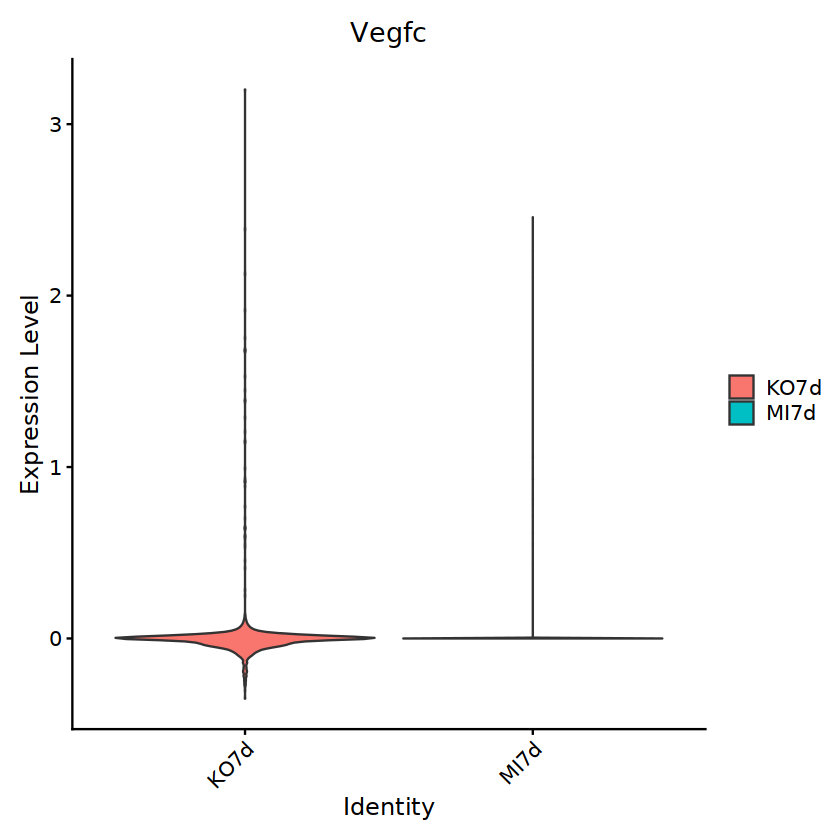

In [13]:
VlnPlot(data,features = 'Vegfc',pt.size = 0)

In [5]:
library(future)
options(future.globals.maxSize = 20 * 1024^3)
plan(multisession, workers = 8) 

Warning message:
"package 'future' was built under R version 4.2.3"


In [6]:
Idents(data) = 'orig.ident'
DefaultAssay(data) = 'RNA'
gene = FindMarkers(data,`ident.1` = 'KO7d',slot="data", assay = "RNA",logfc.threshold = 0, min.pct = 0, test.use = "wilcox")

In [7]:
gene$SYMBOL <- rownames(gene)

In [8]:
df <- bitr(rownames(gene), 
           fromType = "SYMBOL",
           toType =  "ENTREZID",
           OrgDb = 'org.Mm.eg.db')



'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(rownames(gene), fromType = "SYMBOL", toType = "ENTREZID", :
"21.68% of input gene IDs are fail to map..."


In [9]:
need_DEG <- merge(gene, df, by='SYMBOL') 

In [10]:
geneList <- need_DEG$avg_log2FC
names(geneList) <- need_DEG$ENTREZID
geneList <- sort(geneList, decreasing = T) 

In [11]:
GO_kk_entrez <- gseGO(geneList     = geneList,
                      ont          = "BP",  # "BP"、"MF"和"CC"或"ALL"
                      OrgDb        = 'org.Mm.eg.db',#人类org.Hs.eg.db 鼠org.Mm.eg.db
                      keyType      = "ENTREZID",
                      nPermSimple = 10000,
                      pvalueCutoff = 0.25) 

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (1.56% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
leading edge analysis...

done...



In [72]:
KEGG  =GO_kk_entrez@result %>% filter(p.adjust < 0.05 & abs(NES) > 1.5) 

In [73]:
g1 = KEGG
library(tibble)
library(tidyverse)
num<-g1[,c(1,11)]
num<-num%>% separate_rows(core_enrichment, sep = "/")%>%group_by(ID)%>%count()

In [74]:
sum(num$ID==g1$ID)
g1$Count<-num$n
data<-g1%>%mutate(GeneRatio = Count/setSize)
data$sign<-ifelse(data$NES>0,"activated","suppressed")

[1] 0

In [82]:
options(repr.plot.height = 9,repr.plot.width = 13)

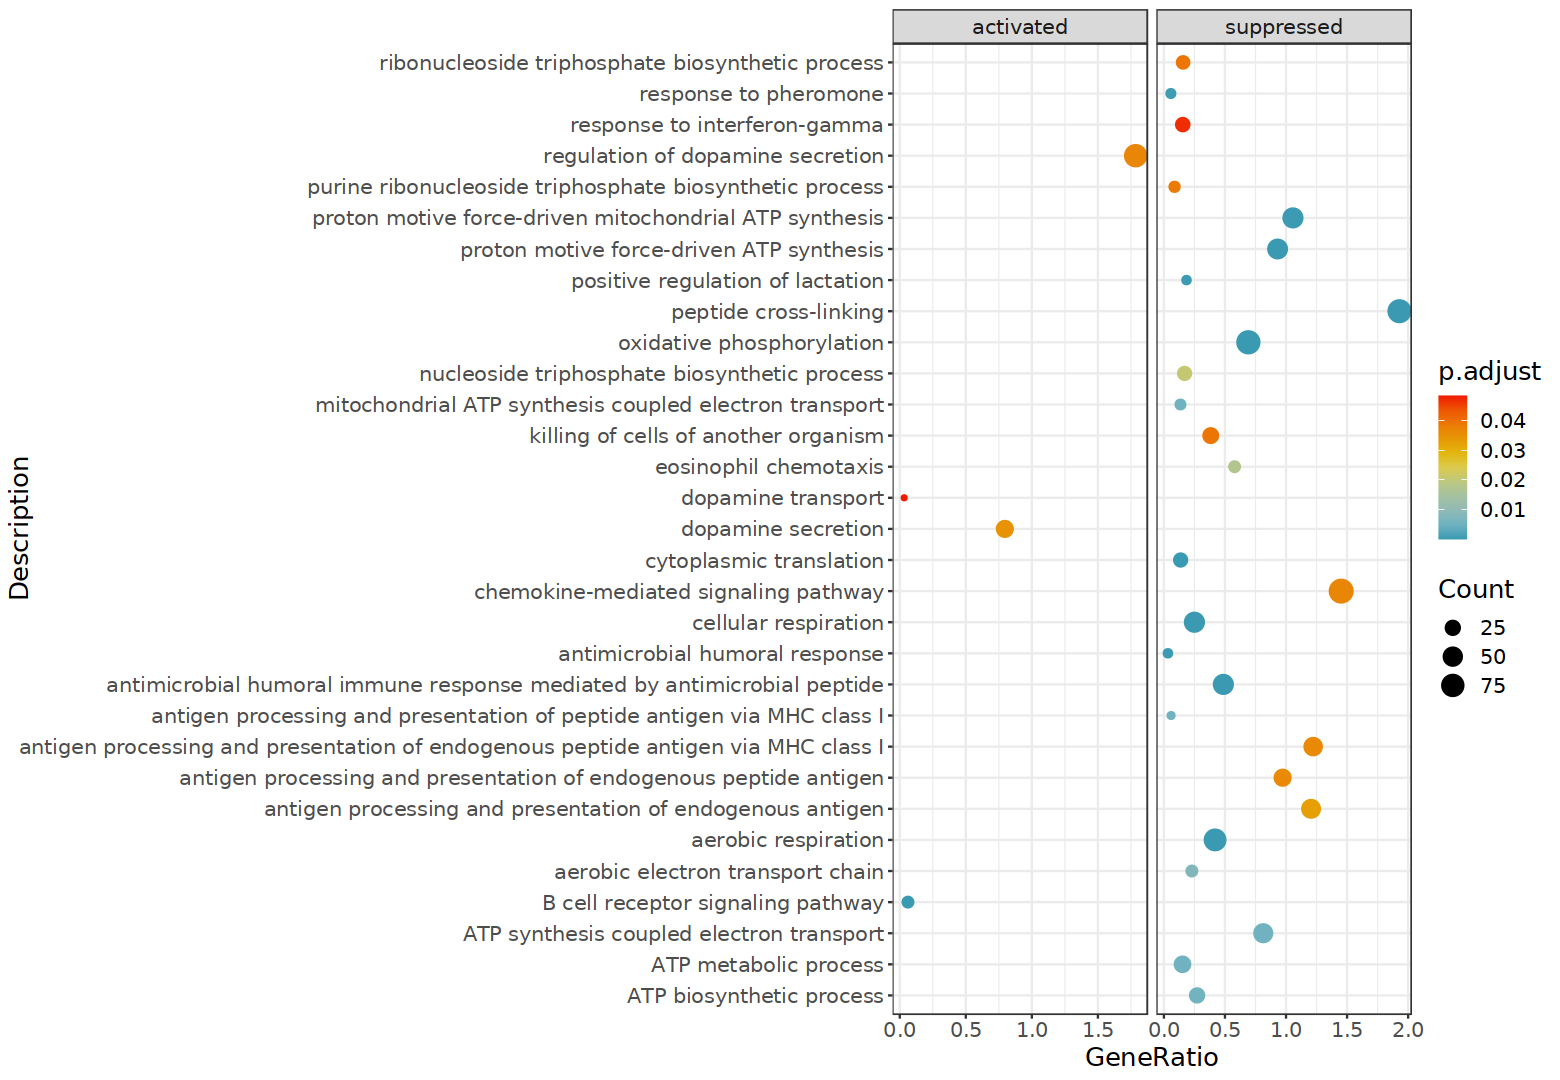

In [83]:
library(RColorBrewer)
library(wesanderson)
ggplot(data)+geom_point(aes(x=GeneRatio ,y=Description,colour=p.adjust,size=Count))+
facet_grid(~sign,scales = "free") +scale_colour_gradientn(colors=wes_palette("Zissou1",80,type="continuous"))+
theme_bw()+ theme(text = element_text(size = 15))
#ggsave('gsea.dotplot.pdf',width = 8,height = 7)